#ENGR E222 2021 Project
#Default ML application for heart failure
This is a default service where we train a logistic regression classifier to the heart failure data set provided in class. Here we build a model to predict, given a set of features, the likelihood of a heart attack. 

## Step 1: Download the kaggle dataset to your google drive
https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a
The above link goes through fetching the .json file from kaggle and putting it
in the correct place to allow you to use the kaggle api to fetch data directly 
to your notebook

the kaggle package is not default in collab

In [ ]:
!pip install -q kaggle 
from google.colab import files
files.upload()

# This below is command line you can also use a mouse and make dir structure
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !ls ~/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json

## Step 2: Mount drive and define paths
Mount the drive you need to enter a link to make this work we need a workaround

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os

data_path = "/content/gdrive/MyDrive/Kaggle"
os.environ['KAGGLE_CONFIG_DIR'] = data_path




In [ ]:
#changing the working directory
%cd /content/gdrive/MyDrive/Kaggle

/content/gdrive/MyDrive/Kaggle


## Step 3: Fetch data from kaggle and unzip

This is from kaggle (navigate to the API tab and copy paste)

In [ ]:
!kaggle datasets download -d andrewmvd/heart-failure-clinical-data

  0% 0.00/3.97k [00:00<?, ?B/s]
100% 3.97k/3.97k [00:00<00:00, 840kB/s]


In [ ]:
# We are now in the dir with our dataset
!ls

heart-failure-clinical-data.zip  hotel_bookings.csv  kaggle.json


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

Archive:  heart-failure-clinical-data.zip
  inflating: heart_failure_clinical_records_dataset.csv  


In [ ]:
!ls

heart_failure_clinical_records_dataset.csv  hotel_bookings.csv	kaggle.json


## Step 4: Explore and clean the data 



 Let's get the data cleaned and arranged
 https://www.kaggle.com/anushkahedaoo/hotel-booking-demand-data-cleaning

 A very useful source is here: https://scikit-learn.org/stable/modules/preprocessing.html

 Section 6.3.4 goes through the processes of encoding categorical features


In [ ]:
import pandas as pd 
import numpy as np
missing_value=["Undefined"]
data = pd.read_csv("heart_failure_clinical_records_dataset.csv", na_values=missing_value) 
data.head()

np.sum(data.isnull())

# Here we are using the 12 features to predict the liklihood of a death event. 

Y = data['DEATH_EVENT']
Y = Y[1:]
X = data.drop(['DEATH_EVENT'], axis=1)
X = X[1:]

print(X.shape, Y.shape)

(298, 12) (298,)


In [ ]:
# Now we need to look at Y
# 70/30

from collections import Counter

original_counts = Counter(Y)
print(original_counts)


# now lets balance the data
from imblearn.over_sampling import SMOTE
over = SMOTE()
X_new, Y_new = over.fit_resample(X,Y)
new_counts = Counter(Y_new)
print(new_counts)

# The deprication warning should be resolved. https://github.com/skorch-dev/skorch/issues/612

Counter({0: 203, 1: 95})
Counter({1: 203, 0: 203})


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Step 5: Create the pipeline with a gridsearch

Here we can get the C parameter for the logistic regression model and the optimal number of features from PCA.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization with out the use of SMOTE.

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_new, Y_new, test_size=0.2, random_state=0)

pca = PCA()

logistic = LogisticRegression(max_iter=100000, tol=0.1)

pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# This grid search is exhaustive and time consuming. 

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [2, 4, 8, 10, 12],
    'logistic__C': np.logspace(-4, 4, 6),
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(x_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)



Best parameter (CV score=0.796):
{'logistic__C': 0.15848931924611143, 'pca__n_components': 8}


In [ ]:
print(search.best_params_)

{'logistic__C': 0.15848931924611143, 'pca__n_components': 8}


In [ ]:
search.best_params_
np.logspace(-4,4,6)

array([1.00000000e-04, 3.98107171e-03, 1.58489319e-01, 6.30957344e+00,
       2.51188643e+02, 1.00000000e+04])

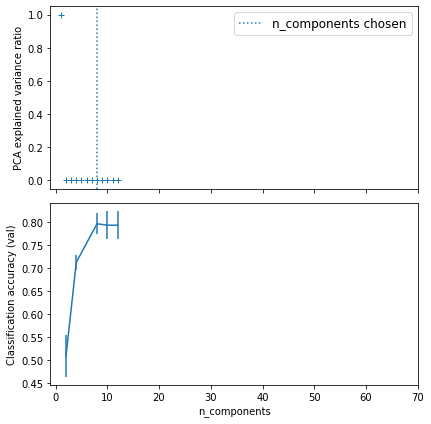

In [ ]:
# Visulaize the PCA
# This section is about using PCA to find the optimal combination of features
# https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html

pca.fit(x_train)

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_, '+', linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
ax0.legend(prop=dict(size=12))

results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col, y='mean_test_score', yerr='std_test_score',
               legend=False, ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 70)

plt.tight_layout()

# Step 6: Use the values from Step 5 to train and evaluate the model

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_new, Y_new, test_size=0.2, random_state=0)

pca = PCA(n_components=8)
stdscl = StandardScaler()
logistic = LogisticRegression(C = 0.15848931924611143, max_iter=100000, tol=0.1)


pipe = Pipeline(steps=[('standardscalar', stdscl),('pca', pca), ('logistic', logistic)])


In [ ]:
my_mdl = pipe.fit(x_train, y_train)

In [ ]:
my_mdl.score(x_test,y_test)

0.8658536585365854

In [ ]:
my_prediction = my_mdl.predict(x_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, my_prediction, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85        38
           1       0.87      0.89      0.88        44

    accuracy                           0.87        82
   macro avg       0.87      0.86      0.86        82
weighted avg       0.87      0.87      0.87        82



In [ ]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y_test, my_prediction)
conf

array([[32,  6],
       [ 5, 39]])

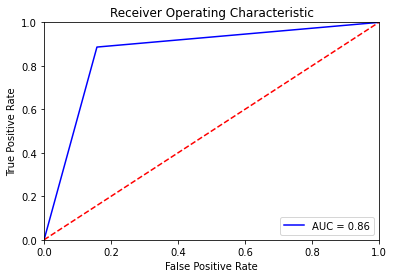

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = pipe.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, my_prediction)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()